In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import prettytensor as pt
from numpy.random import multivariate_normal,random_sample
from datetime import datetime
%matplotlib inline

In [2]:
latent_size = 2
batch_size = 200
data_size = 2

# for Adam optimizer:
eta = 2e-4
beta1 = 0.5

# Data distribution $p_{data}$

$$
p_{data} = \mathcal{N}\bigg((1,1), 
\begin{pmatrix}
1 & 0.9\\
0.9 & 1\\
\end{pmatrix}
\bigg)
$$

In [3]:
def gen_data(n_samples):
    """generate data according to p_data"""
    mean = [1,1]
    covariance = [[1,0.9], [0.9,1]]
    return multivariate_normal(mean, covariance, n_samples)

def gen_noise(batch_size, latent_dim):
    """generate n_samples of random noise"""
    return random_sample((batch_size, latent_dim))

In [4]:
def viz_data(data):
    """Plot a scatterplot of the given data"""
    assert data.shape[1] == 2
    plt.scatter(data[:,0], data[:,1], edgecolors='face', alpha=0.3, marker='o', linewidths=0.1)

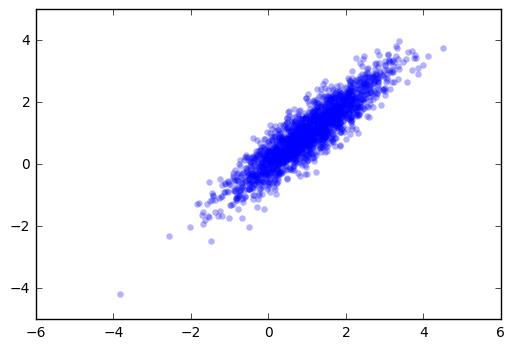

In [5]:
viz_data(gen_data(2000))

In [6]:
def generator(input_data):
    with pt.defaults_scope(activation_fn=tf.nn.tanh, variable_collections=['generator']):
        return (pt.wrap(input_data).flatten()
               .fully_connected(100)
               .fully_connected(100)
               .fully_connected(2))

In [7]:
def discriminator(input_data):
    with pt.defaults_scope(activation_fn=tf.nn.tanh, variable_collections=['discriminator']):
        return (pt.wrap(input_data).flatten()
               .fully_connected(100)
               .fully_connected(100)
               .fully_connected(1, activation_fn=tf.nn.sigmoid)
               )

In [8]:
tf.reset_default_graph()
data_tensor = tf.placeholder(np.float32, shape=(batch_size, data_size))
noise_tensor = tf.placeholder(np.float32, shape=(batch_size, latent_size))


output_g = generator(noise_tensor)
output_d_real = discriminator(data_tensor)
output_d_fake = discriminator(output_g)

# discriminator loss (for both cases)
loss_d_real = -tf.reduce_mean(tf.log(output_d_real + 1e-12))
loss_d_fake = -tf.reduce_mean(tf.log((1 - output_d_fake) + 1e-12))
loss_d = loss_d_real + loss_d_fake

# generator loss
loss_g = -tf.reduce_mean(tf.log(loss_d_fake + 1e-12))

In [9]:
summary_d = [
    tf.scalar_summary('loss_d_real', loss_d_real),
    tf.scalar_summary('loss_d_fake', loss_d_fake)
    ]
summary_g = [
    tf.scalar_summary('loss_g', loss_g)
]
merged_d = tf.merge_summary(summary_d)
merged_g = tf.merge_summary(summary_g)

In [10]:
vars_d = tf.get_collection('discriminator')
vars_g = tf.get_collection('generator')

In [11]:
assert len(vars_g) == 6
assert len(vars_d) == len(vars_g) * 2

In [12]:
opt_d = tf.train.AdamOptimizer(eta, beta1=beta1)\
            .minimize(loss_d, var_list = vars_d)

opt_g = tf.train.AdamOptimizer(eta, beta1=beta1)\
            .minimize(loss_g, var_list = vars_g)

In [13]:
init_op = tf.initialize_all_variables()

In [14]:
sess = tf.Session()
sess.run(init_op)

In [15]:
now = str(datetime.now()).replace(' ', '_').replace(':', '_')
sum_writer = tf.train.SummaryWriter('logs_{}/'.format(now))

In [16]:
# update discriminator once
real_data = gen_data(batch_size)
noise = gen_noise(batch_size, latent_size)
l_d, summary = sess.run([loss_d, merged_d], {data_tensor: real_data, noise_tensor: noise})
sum_writer.add_summary(summary)

In [17]:
noise = gen_noise(batch_size, latent_size)
l_g, summary = sess.run([loss_g, merged_g], {noise_tensor: noise})
sum_writer.add_summary(summary)

In [18]:
num_epochs = 20000
n_k = 10

for epoch in range(0, num_epochs):
    # update discriminator $k$ times
    for k in range(0, n_k):
        real_data = gen_data(batch_size)
        noise = gen_noise(batch_size, latent_size)
        # run discriminator on real data this time
        l_d, summary = sess.run([loss_d, merged_d], {data_tensor: real_data, noise_tensor: noise})
        if k == n_k-1:
            sum_writer.add_summary(summary, epoch)
    noise = gen_noise(batch_size, latent_size)
    l_g, summary = sess.run([loss_g, merged_g], {noise_tensor: noise})
    sum_writer.add_summary(summary, epoch)
    if epoch % 100 == 0:
        print('epoch {}/{}: {}%'.format(epoch, num_epochs, epoch/num_epochs))

epoch 0/20000: 0.0%
epoch 100/20000: 0.005%
epoch 200/20000: 0.01%
epoch 300/20000: 0.015%
epoch 400/20000: 0.02%
epoch 500/20000: 0.025%
epoch 600/20000: 0.03%
epoch 700/20000: 0.035%
epoch 800/20000: 0.04%
epoch 900/20000: 0.045%
epoch 1000/20000: 0.05%
epoch 1100/20000: 0.055%
epoch 1200/20000: 0.06%
epoch 1300/20000: 0.065%
epoch 1400/20000: 0.07%
epoch 1500/20000: 0.075%
epoch 1600/20000: 0.08%
epoch 1700/20000: 0.085%
epoch 1800/20000: 0.09%
epoch 1900/20000: 0.095%
epoch 2000/20000: 0.1%
epoch 2100/20000: 0.105%
epoch 2200/20000: 0.11%
epoch 2300/20000: 0.115%
epoch 2400/20000: 0.12%
epoch 2500/20000: 0.125%
epoch 2600/20000: 0.13%
epoch 2700/20000: 0.135%
epoch 2800/20000: 0.14%
epoch 2900/20000: 0.145%
epoch 3000/20000: 0.15%
epoch 3100/20000: 0.155%
epoch 3200/20000: 0.16%
epoch 3300/20000: 0.165%
epoch 3400/20000: 0.17%
epoch 3500/20000: 0.175%
epoch 3600/20000: 0.18%
epoch 3700/20000: 0.185%
epoch 3800/20000: 0.19%
epoch 3900/20000: 0.195%
epoch 4000/20000: 0.2%
epoch 4100/

KeyboardInterrupt: 